#### Activity 1.4: SOR for finite elements

4 points

**collaboration statement:**

In [1]:
%pip install numpy
%pip install scipy
%pip install matplotlib
import numpy as np
from numpy.linalg import eigvals
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, dia_matrix, eye, diags, kron, tril
from scipy.sparse.linalg import eigs, spsolve

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Motivation: finite elements

In the lecture I say that the finite element Laplacian $L_h^{\text{FE}}$ is interpreted in the following way: the vectors $v$ and $u$ represent functons $v_h$ and $u_h$, and
$$v^T L_h^{\text{FE}} u_h = \int_{\Omega} \nabla v_h \cdot \nabla u_h\ dx.$$

One interesting thing is that if we take equally spaced grid points in the interval $(0,1)$ and let each component $u_i$ of the vector represent a function that is piecewise linear and equal to $1$ at $x_i$ and $0$ at all other grid points, the finite element Laplacian is the same as the finite difference Laplacian, only scaled differently:

$$L_h^{\text{FE,1D}} = h L_h^{\text{FD,1D}},$$

where $h = 1/(n+1)$.

If we go to 2D there are a few different ways that we can construct a finite element matrix on the regular grid, but they aren't the same as the finite difference matrix.

In the code below, I have a function that will construct either a finite difference or finite element 2D Laplacian:

In [2]:
def laplacian_2d(n, discretization='FD', aspect_ratio=1.):
    h_x = 1. / (n + 1.)
    h_y = aspect_ratio / (n + 1.)
    L_x = dia_matrix((np.array([[-1.],[2.],[-1.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
    L_y = L_x.copy()
    if discretization == 'FE':
        L_x /= h_x
        L_y /= h_y
    else:
        L_x /= h_x**2
        L_y /= h_y**2
    if discretization == 'FE':
        M_x = dia_matrix((np.array([[1./6.],[2./3.],[1./6.]]) * np.ones((1,n)),[-1,0,1]), shape=(n,n))
        M_y = M_x.copy()
        M_x *= h_x
        M_y *= h_y
    else:
        M_x = eye(n)
        M_y = eye(n)
    return kron(L_x, M_y) + kron(M_x, L_y)
    

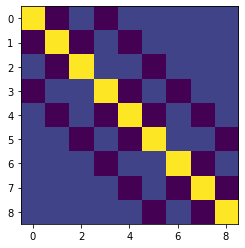

In [3]:
plt.imshow(laplacian_2d(3, 'FD').toarray())

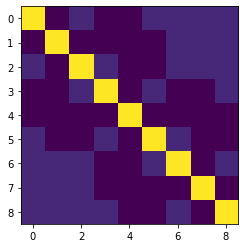

In [4]:
plt.imshow(laplacian_2d(3, 'FE').toarray())

You'll notice that there are more non-zeros in the finite element matrix.  This is because the type of finite elements we're using make it a 9-point stencil instead of a 5-point stencil.  The finite element matrix is not consistently ordered.  This means that **the formula to choose an optimal $\omega$ for SOR does not apply**.

The function `laplacian_2d` also takes an `aspect_ratio` optional argument that gives different grid spacing in the $x$ and $y$ directions.

From what we've seen of finite differences, we know that $L_h^{\text{FD,2D}}$ will be

- irreducibly diagonally dominant
- an M-matrix
- consistently ordered

for every aspect ratio.

What about the finite element matrix?

Here is a function that returns

$$\min_i |A_{i,i}| - \sum_{j\neq i} |A_{i,j}|$$

It will be $< 0$ if the matrix is not diagonally dominant.

In [5]:
def min_diagonal_dominance(A):
    Aabs = np.absolute(A)
    Aabsdiag = Aabs.diagonal()
    Aabs -= diags(Aabsdiag)
    off_diagonal_sum = Aabs * np.ones(A.shape[1])
    return np.min(Aabsdiag - off_diagonal_sum)

In [6]:
min_diagonal_dominance(laplacian_2d(3, 'FD'))

0.0

In [7]:
min_diagonal_dominance(laplacian_2d(3, 'FE'))

0.0

Here is a function that returns the largest off diagonal entry.  If it is $> 0$, the matrix is not an L-matrix.

In [9]:
def largest_off_diagonal(A):
    return (A - diags(A.diagonal())).max()

In [10]:
largest_off_diagonal(laplacian_2d(3,'FD'))

0.0

In [11]:
largest_off_diagonal(laplacian_2d(3,'FE'))

0.0

**Activity 1 (2 point):** For $n=10$, plot `min_diagonal_dominance` and `largest_off_diagonal` for the finite element Laplacian for some aspect ratios.   Then say for which aspect ratios it will be weakly diagonally dominant and for which aspect ratios it will be an L-matrix (note that by design the finite element matrix will always be SPD, so it is an L-matrix if and only if it is an M-matrix).

In [16]:
# make your plot here
largest_off_diagonal(laplacian_2d(3,'FE',aspect_ratio=0.01))
ars = np.linspace(0.1,100.)
md = [min_diagonal_dominance(laplacian_2d(10,'FE',aspect_ratio=a)) for a in ars]

YOUR ANSWER HERE

Here is a robust code to compute the spectral radius:

In [ ]:
def rho(A):
    if not isinstance(A, np.ndarray):
        A = A.toarray()
    evs = eigvals(A)
    return np.abs(evs).max()

Here is our usual code to compute the Jacobi iteration matrix:

In [ ]:
def G_J(A):
    D = A.diagonal()
    n = A.shape[0]
    return eye(n) - diags(1./D) @ A

Here is code to compute the SOR iteration matrix:

In [ ]:
def G_SOR(omega, A):
    D = diags(A.diagonal())
    E = -tril(A,-1)
    M = (1./omega)*D - E
    N = M - A
    return spsolve(M, N.toarray())

And here is the formula to compute the optimal $\omega$ from $\rho(G_J)$ for a consistently ordered matrix:

In [ ]:
def consistently_ordered_optimal_omega(rhoGJ):
    return 2. / (1. + (1. - rhoGJ**2)**0.5)

**Activity 2 (2 points):** Make one plot for each aspect ratios $\alpha = 1, 2, 4, 8$.  On each, make the x axis $\omega$ and the y axis $\rho(G_\omega)$.  Then, plot two lines: $\rho(G_{\omega}(L_{\alpha,h}^{\text{FE}}))$ and
$\rho(G_{\omega}(L_{\alpha,h}^{\text{FD}}))$ for $n=10$ and $\omega \in (0,2)$.  Finally, plot the optimal $\omega$ for $L_{\alpha,h}^{\text{FD}}$ as a vertical line.  Comment on what you see.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE